In [1]:
from pmotifs.config import config

In [2]:
from pathlib import Path



ANALYSIS_CANDIDATES = {
    "yeast": {
        "edgelist": config.DATASET_DIRECTORY /  "yeastInter_st.txt",
        "outpath": config.EXPERIMENT_OUT / "pmotif_detection",
    },
}

In [3]:
CANDIDATE = "yeast"

GRAPH_EDGELIST = ANALYSIS_CANDIDATES[CANDIDATE]["edgelist"]
OUT = ANALYSIS_CANDIDATES[CANDIDATE]["outpath"]
GRAPHLET_SIZE = 3

In [4]:
# Retrieve Graphlets and their metrics
from pmotifs.PMotifGraph import PMotifGraph


g = PMotifGraph(GRAPH_EDGELIST, OUT)

In [5]:
g_p = g.load_graphlet_pos_zip(GRAPHLET_SIZE)

Load Graphlet Positions: 100%|█████████| 13150/13150 [00:00<00:00, 94403.89it/s]


In [6]:
g_pm = g.load_positional_data(GRAPHLET_SIZE)

Loading Graphlet Metrics: 100%|████████| 13150/13150 [00:00<00:00, 79311.92it/s]


In [7]:
graphlet_lookup = dict(zip(g_p, g_pm.graphlet_metrics))

In [8]:
import pandas as pd

df = pd.DataFrame([
    {**k.__dict__, **v.__dict__}
    for k,v in graphlet_lookup.items()
])
df.head()

,graphlet_class,nodes,degree,anchor_node_distances,graph_module_participation
0,011 100 100,"[1, 199, 352]",10,"[4, 3, 2, 1, 2, 5, 2, 3, 4, 4, 3, 2, 3, 2, 3, ...",[0]
1,011 100 100,"[1, 199, 203]",8,"[4, 3, 3, 1, 2, 4, 1, 4, 4, 3, 4, 3, 3, 3, 3, ...","[0, 10]"
2,011 100 100,"[1, 199, 200]",9,"[3, 3, 3, 1, 1, 4, 1, 3, 4, 3, 3, 3, 3, 3, 3, ...","[0, 10]"
3,011 100 100,"[1, 199, 198]",11,"[3, 2, 2, 1, 2, 4, 1, 3, 3, 3, 3, 2, 3, 2, 3, ...",[0]
4,011 100 100,"[1, 199, 197]",17,"[3, 2, 2, 0, 2, 4, 1, 3, 3, 3, 3, 2, 2, 2, 2, ...",[0]


In [9]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

# Analysis

In [10]:
from statistics import quantiles

def elements_in_percentile(elements, percentile, above=True):
    elements = sorted(elements)
    
    percentile_cuts = quantiles(elements, n=100, method="inclusive")
    cutoff = percentile_cuts[percentile - 1]

    comparator = lambda e: e > cutoff
    if not above:
        comparator = lambda e: e < cutoff
        
    return [e for e in elements if comparator(e)]


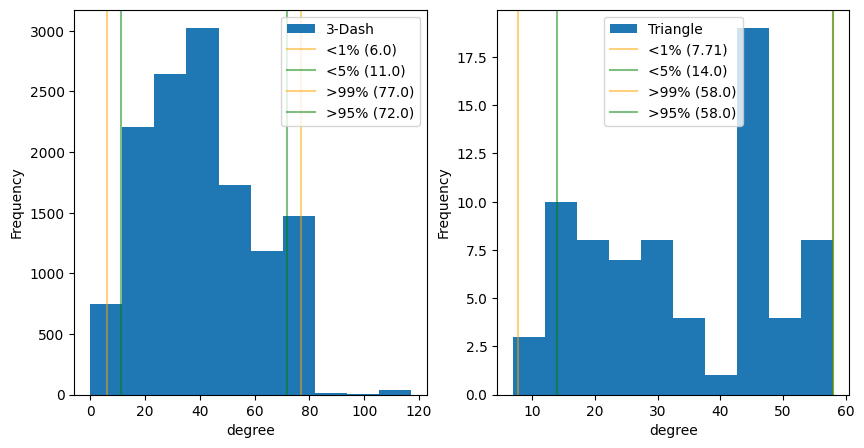

In [11]:
import matplotlib.pyplot as plt

from pmotifs.graphlet_representation import graphlet_class_to_name

METRIC_NAME = "degree"

fig, axes = plt.subplots(1, len(graphlet_classes), figsize=(len(graphlet_classes) * 5, 5))

for i, graphlet_class in enumerate(graphlet_classes):
    ax = axes[i]

    metric = df[df["graphlet_class"] == graphlet_class][METRIC_NAME]
        
    percentile_cuts = quantiles(metric, n=100, method="inclusive")
    
    ax.hist(metric, label=graphlet_class_to_name(graphlet_class))
    ax.axvline(percentile_cuts[0], label=f"<1% ({percentile_cuts[0]})", color="orange", alpha=0.5)
    ax.axvline(percentile_cuts[4], label=f"<5% ({percentile_cuts[4]})", color="green", alpha=0.5)
    ax.axvline(percentile_cuts[-1], label=f">99% ({percentile_cuts[-1]})", color="orange", alpha=0.5)
    ax.axvline(percentile_cuts[-5], label=f">95% ({percentile_cuts[-5]})", color="green", alpha=0.5)
    
    
    ax.legend()
    ax.set_xlabel(METRIC_NAME)
    ax.set_ylabel("Frequency")

In [12]:
import networkx as nx

def prepare_kamada_kawai_layout_with_multiple_components(nx_g):
    pos_df = pd.DataFrame(index=nx_g.nodes(), columns=nx_g.nodes())
    max_dist = -1
    for row, data in nx.shortest_path_length(nx_g):
        for col, dist in data.items():
            pos_df.loc[row,col] = dist
            max_dist = max(max_dist, dist)

    pos_df = pos_df.fillna(max_dist / 2 + 2)

    return nx.kamada_kawai_layout(nx_g, dist=pos_df.to_dict())

In [13]:
"""Prepare Graph Plotting"""
import networkx as nx

nx_g = g.load_graph()
pos = prepare_kamada_kawai_layout_with_multiple_components(nx_g)

In [14]:
def highlight_motif(nx_g, motif, ax, pos):
    subgraph = nx.induced_subgraph(nx_g, motif)

    nx.draw_networkx_nodes(
        nx_g,
        nodelist=subgraph.nodes,
        node_color='r',
        pos=pos,
        ax=ax,
        node_size=20,
    )
    nx.draw_networkx_labels(
        nx_g,
        labels={node: node for node in subgraph.nodes},
        pos=pos,
        ax=ax,
        font_size=6,
        font_color='b',
    )
    nx.draw_networkx_edges(
        nx_g,
        pos=pos,
        edgelist=subgraph.edges,
        ax=ax,
        edge_color="r",
    )

In [15]:
def get_quantile_filters(metric_name, graphlet_df):
    metric = graphlet_df[metric_name]
    percentile_cuts = quantiles(metric, n=100, method="inclusive")

    below_1p = lambda e: e < percentile_cuts[0]
    below_5p = lambda e: e < percentile_cuts[4]

    above_1p = lambda e: e > percentile_cuts[-1]
    above_5p = lambda e: e > percentile_cuts[-5]

    return {
        "below_1p": below_1p,
        "below_5p": below_5p,
        "above_1p": above_1p,
        "above_5p": above_5p,
    }

In [16]:
def plot_graph_with_motif_highlight(nx_g, motifs, pos, ax, title=""):
    nx.draw(nx_g, pos=pos, ax=ax, node_size=20)

    for m in motifs:
        highlight_motif(nx_g, m, ax, pos)

    ax.set_title(title)

In [17]:
def filter_motifs_by_quantile(graphlet_df, quantile_name, quantile_filters=None):
    if quantile_filters is None:
        quantile_filters = get_quantile_filters(METRIC_NAME, graphlet_df)
    
    kept_positions = [
        quantile_filters[quantile_name](e)
        for e in graphlet_df[METRIC_NAME]
    ]
    
    return list(graphlet_df[kept_positions]["nodes"])

In [18]:
from pmotifs.graphlet_representation import graphlet_name_to_class


def plot_single(graphlet_class_name, quantile_filter_name):
    graphlet_class = graphlet_name_to_class(graphlet_class_name)
    
    graphlet_class_df = df[df["graphlet_class"] == graphlet_class]
    
    fig, ax= plt.subplots(1, 1, figsize=(10, 10))

    interesting_motifs = filter_motifs_by_quantile(
        graphlet_class_df,
        quantile_filter_name,
    )

    plot_graph_with_motif_highlight(
        nx_g,
        interesting_motifs,
        pos,
        ax,
        title=f"{quantile_filter_name} ({len(interesting_motifs)})",
    )

    fig.suptitle(graphlet_class_to_name(graphlet_class))

In [19]:
import networkx as nx


def plot_quantiles(graphlet_class):
    graphlet_class_df = df[df["graphlet_class"] == graphlet_class]

    quantile_filters = get_quantile_filters(METRIC_NAME, graphlet_class_df)


    fig, axes = plt.subplots(1,len(quantile_filters), figsize=(20,5,))

    for i, quantile_filter_name in enumerate(quantile_filters):
        ax = axes[i]

        interesting_motifs = filter_motifs_by_quantile(
            graphlet_class_df,
            quantile_filter_name,
            quantile_filters=quantile_filters,
        )

        plot_graph_with_motif_highlight(
            nx_g,
            interesting_motifs,
            pos,
            ax,
            title=f"{quantile_filter_name} ({len(interesting_motifs)})",
        )

    fig.suptitle(graphlet_class_to_name(graphlet_class))

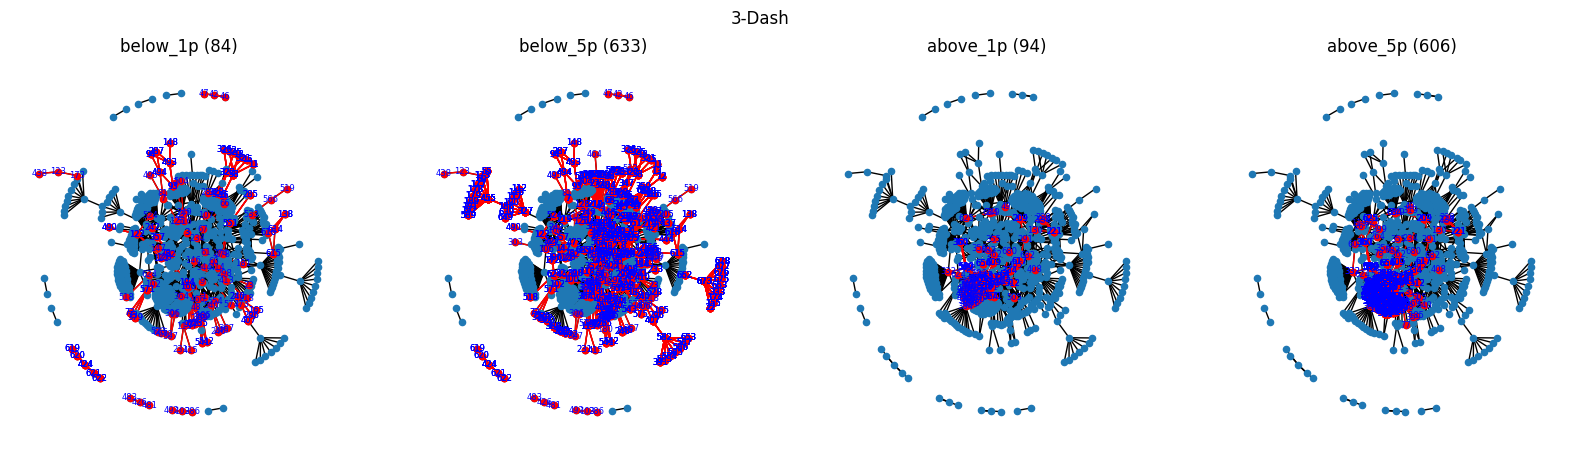

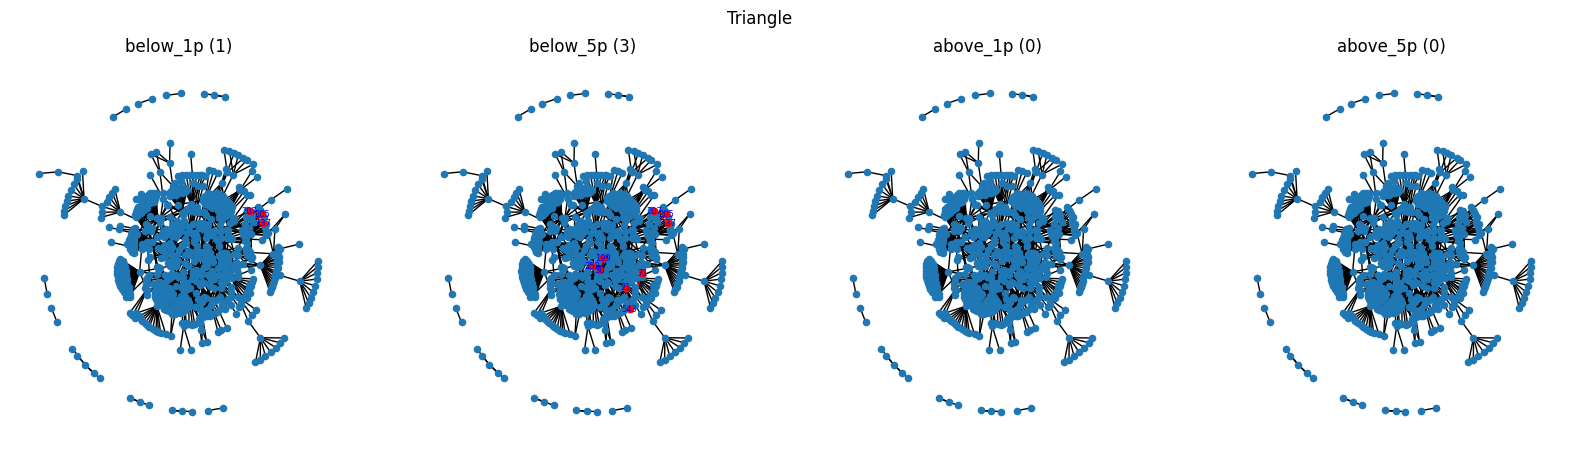

In [20]:
for graphlet_class in graphlet_classes:
    plot_quantiles(graphlet_class)

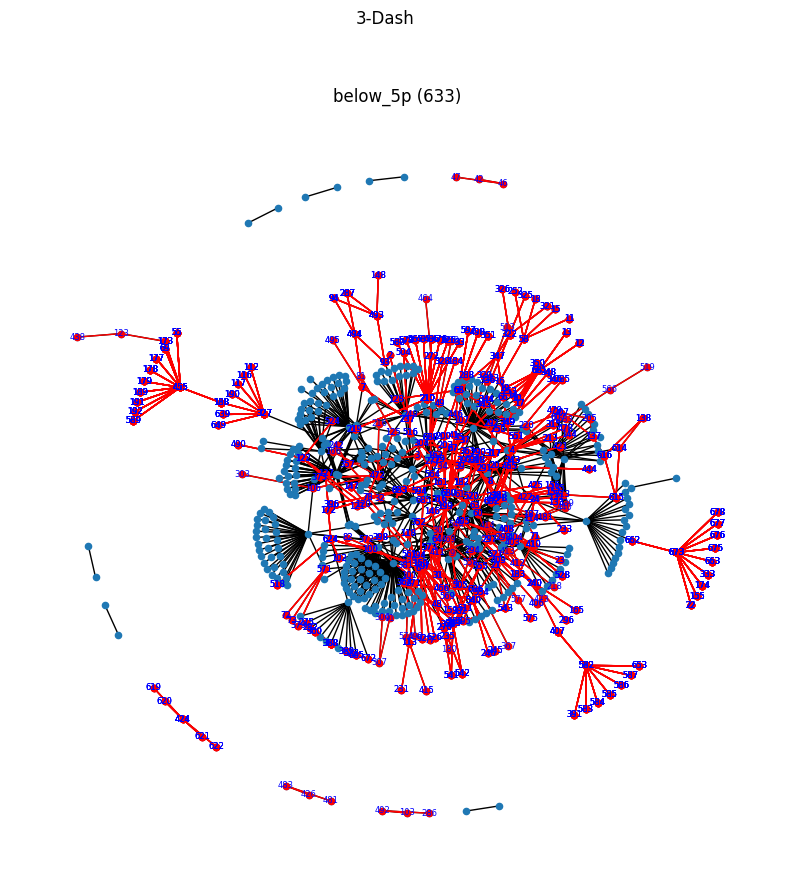

In [21]:
plot_single(graphlet_class_name="3-Dash", quantile_filter_name="below_5p")